In [3]:
from itertools import product
import numpy as np

In [4]:
def wasserstein2(u: np.array, v: np.array):
    """
    Returns the squared 2-Wasserstein distance between two
    empirical distributions represented by arrays.
    Assumes the arrays of equal size.
    """
    assert len(u) == len(v)
    
    u_sorted = np.sort(u)
    v_sorted = np.sort(v)
    
    return np.sum(np.power(u_sorted - v_sorted,2)) / len(u)

In [58]:
r = 3
c = 3
n = 100

data_table = [[0 for i in range(c)] for j in range(r)]

np.random.seed(0)

# Table of n x m Gaussians with columns having same variance and rows having same means

# means = np.linspace(-10,10,num=r) # means
# stds = np.linspace(1, 20, num=c) # variances
means = [0] * r # means
stds = [1, 2, 1] # variances

for i, j in product(range(r),range(c)):
    data_table[i][j] = np.random.normal(means[i],stds[j], n)

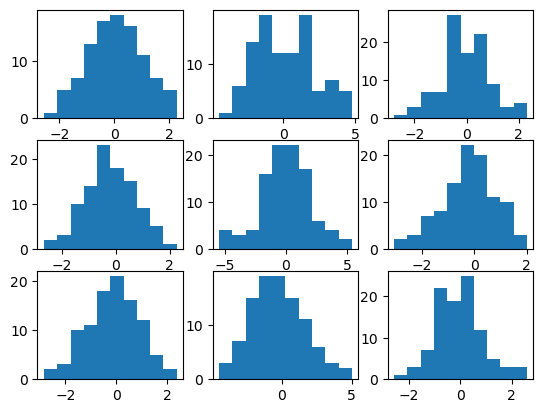

In [64]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(r, c)

for i in range(r):
    for j in range(c):
        axs[i, j].hist(data_table[i][j], bins=n // 10)

In [60]:
for i, j in product(range(r),range(c)):
    print(i,j,np.mean(data_table[i][j]), np.std(data_table[i][j]))

0 0 0.05980801553448501 1.0078822447165796
0 1 0.1640259414956747 2.069333994876845
0 2 -0.05923226055966314 0.9520026189951111
1 0 -0.19679670654591028 0.9293551189400339
1 1 -0.025128431677836054 2.0743464226204735
1 2 -0.20293097988992734 1.0169771787257058
2 0 -0.13494963016348158 1.0030129643138403
2 1 -0.2471985670456201 1.8832778073001464
2 2 -0.028199131755383324 0.9299670866405886


In [67]:
dissim(get_col(data_table, 0), get_col(data_table, 1))

1.1287208910401585

In [68]:
dissim(get_col(data_table, 0), get_col(data_table, 2))

0.03370404333464019

In [ ]:
dissim(data_table[0], data_table[1])

In [50]:
def dissim(list1: list[np.array], list2: list[np.array]) -> float:
    size = 0
    distance = 0
    for ind in range(len(list1)):
        if len(list1[ind]) > 0 and len(list2[ind]) > 0: # both are observed
            distance += wasserstein2(list1[ind],list2[ind])
            size += 1
    if size == 0:
        return float('inf')
    return distance / size

def get_col(table, col):
    return [table[i][col] for i in range(len(table))]

def barycenter(lists):
    # assumes that each list has the same number of samples
    for i in range(len(lists)):
        for j in range(i+1,len(lists)):
            assert len(lists[i]) == len(lists[j])
    
    sorted_data = [np.sort(l) for l in lists]
    
    sum_data = 0
    for l in sorted_data:
        sum_data += l
    
    return sum_data / len(lists)

In [63]:
row1_bc = barycenter(data_table[1:][0] + get_col(data_table, 0)[1:][0])

np.mean(row1_bc), np.std(row1_bc)

(-0.33841541258380153, 1.861516333228331)

In [114]:
dissim(get_col(data_table, 0), get_col(data_table, 1))

15630.549614796368

In [105]:
dissim(data_table[0], data_table[1])

15880.66126213654

In [100]:
from copy import deepcopy

Z = deepcopy(data_table)

Z[0][0] = []

In [ ]:
# Let's try to recreate the (0,0) entry in data_table from Z
